Data Source: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

Kaggle: https://www.kaggle.com/brandao/diabetes/home

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [19]:
data_raw = pd.read_csv('diabetic_data.csv')
data_raw.shape

(101766, 50)

In [20]:
# Drop ids and features with >50% missing values
data = data_raw.drop(['encounter_id','patient_nbr','weight','payer_code','medical_specialty'],axis = 1)
data.shape

(101766, 45)

In [4]:
# Fill NA race values as 'Other'
data.race = data.race.replace('?','Other')
data.race.value_counts()

Caucasian          76099
AfricanAmerican    19210
Other               3779
Hispanic            2037
Asian                641
Name: race, dtype: int64

In [5]:
# only weight and diags contain missing values
data.replace('?',np.nan).isnull().sum().sort_values(ascending = False).head()

diag_3         1423
diag_2          358
diag_1           21
readmitted        0
nateglinide       0
dtype: int64

In [6]:
#  we consider only complete data by dropping missing values
data_comp = data.replace('?',np.nan).dropna()

## Convert categorical features to numeric
- readmitted: `{'>30':1, '<30':2,'NO':0}`
- medication information: into `1` or `0`.
- race: `{'AfricanAmerican':1, 'Asian':2, 'Caucasian':3,'Hispanic':4, 'Other':5}`             

- gender `{'Female':0,'Male':1}`, drop other values
- age:
- change: `{'Ch':1, 'No':0}`

In [7]:
data_clean = data_comp.copy()
data_clean.shape

(100244, 45)

In [8]:
# replace the categories of 'readmitted' as 0,1
data_clean.readmitted = data_clean.readmitted.map({'>30':1, '<30':1,'NO':0})

#replace medication information into indicator values 1 and 0
data_clean.iloc[:,19:42] = data_clean.iloc[:,19:42].replace(['Steady','Down','Up','No'],[1,1,1,0])

In [9]:
race_map = {'AfricanAmerican':10, 'Asian':20, 'Caucasian':30,'Hispanic':40, 'Other':5}
data_clean.race = data_clean.race.map(race_map)

gender_map = {'Female':0,'Male':10, 'Unknown/Invalid':np.nan}
data_clean.gender = data_clean.gender.map(gender_map)
data_clean = data_clean.dropna()
data_clean.gender = data_clean.gender.astype('int64')


glu_map = {'None':0, 'Norm':10,'>200':20, '>300':30}
data_clean.max_glu_serum = data_clean.max_glu_serum.map(glu_map)


A1C_map = {'None':0, 'Norm':10, '>7':20, '>8':30}
data_clean.A1Cresult = data_clean.A1Cresult.map(A1C_map)

age_map = {'[0-10)':10,'[10-20)':10, '[20-30)':20, '[30-40)':30, '[40-50)':40, '[50-60)':50, '[60-70)':60, '[70-80)':70, '[80-90)':70, '[90-100)':70}
data_clean.age = data_clean.age.map(age_map)

data_clean.change = data_clean.change.map({'Ch':10,'No':0})
data_clean.diabetesMed = data_clean.diabetesMed.map({'Yes':10, 'No':0})
data_clean.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,30,0,10,1,1,7,3,59,0,18,...,0,1,0,0,0,0,0,10,10,1
2,10,0,20,1,1,7,2,11,5,13,...,0,0,0,0,0,0,0,0,10,0
3,30,10,30,1,1,7,2,44,1,16,...,0,1,0,0,0,0,0,10,10,0
4,30,10,40,1,1,7,1,51,0,8,...,0,1,0,0,0,0,0,10,10,0
5,30,10,50,2,1,2,3,31,6,16,...,0,1,0,0,0,0,0,0,10,1


In [10]:
diags = data_clean[['diag_1','diag_2','diag_3']]
diags.head()

,diag_1,diag_2,diag_3
1,276,250.01,255
2,648,250,V27
3,8,250.43,403
4,197,157,250
5,414,411,250


In [11]:
target = data_clean.readmitted
features = data_clean.drop(['readmitted'], axis = 1)
num_features = features.select_dtypes(include = ['int64'])

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(num_features, target,
                                                    random_state = 0)

In [14]:
X_train.shape

(75180, 41)

In [22]:
X_test.shape

(25061, 41)

In [23]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_scr = logreg.score(X_train, y_train)
logreg_scr

0.61742484703378553

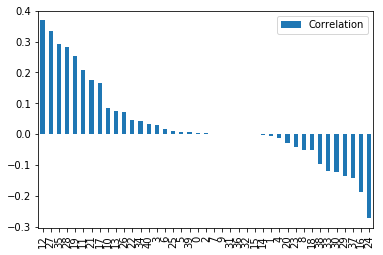

In [24]:
coef_df = pd.DataFrame(logreg.coef_[0],X_train.columns).reset_index().rename(columns = {'index':'Feature',0:'Correlation'})
coef_df.sort_values(by = 'Correlation', ascending = False).plot.bar()

In [25]:
poor_index = coef_df[(coef_df['Correlation'] < 0.02) & (coef_df['Correlation'] > -0.02)].Feature
poor_index

0                         race
1                       gender
2                          age
4     discharge_disposition_id
5          admission_source_id
6             time_in_hospital
7           num_lab_procedures
9              num_medications
14               max_glu_serum
15                   A1Cresult
25                pioglitazone
31                     examide
32                 citoglipton
36    glimepiride-pioglitazone
39                      change
Name: Feature, dtype: object

In [27]:
good_index = coef_df[(coef_df['Correlation'] > 0.1) | (coef_df['Correlation'] < -0.1)].Feature
good_index

11           number_emergency
12           number_inpatient
16                  metformin
17                repaglinide
19             chlorpropamide
21              acetohexamide
24                tolbutamide
27                   acarbose
28                   miglitol
29               troglitazone
30                 tolazamide
33                    insulin
35        glipizide-metformin
37    metformin-rosiglitazone
Name: Feature, dtype: object

In [28]:
good_features = num_features[good_index]
good_features.shape

(100241, 14)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(good_features, target,
                                                    random_state = 0)

In [30]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
random_forest.score(X_train, y_train)

0.61649374833732373

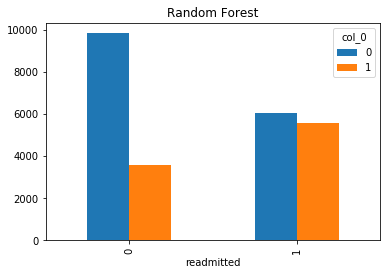

In [99]:
forest_pred = random_forest.predict(X_test)
pd.crosstab(y_test, forest_pred).plot.bar(title = 'Random Forest')

In [50]:
logreg2 = LogisticRegression()
logreg2.fit(X_train, y_train)
logreg2_scr = logreg2.score(X_train, y_train)
logreg2_scr

0.61174514498536847

In [51]:
coef_df2 = pd.DataFrame(logreg2.coef_[0],X_train.columns).reset_index().rename(columns = {'index':'Feature',0:'Correlation'})
coef_df2.sort_values(by = 'Correlation', ascending = False)

,Feature,Correlation
7,acarbose,0.696872
12,glipizide-metformin,0.485020
9,troglitazone,0.464652
5,acetohexamide,0.463768
1,number_inpatient,0.391785
8,miglitol,0.364880
0,number_emergency,0.257467
3,repaglinide,0.229690
4,chlorpropamide,0.132801
11,insulin,0.119263


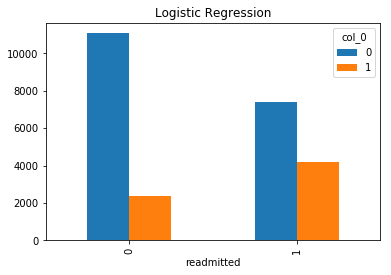

In [35]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
decision_tree.score(X_train, y_train)

0.61649374833732373

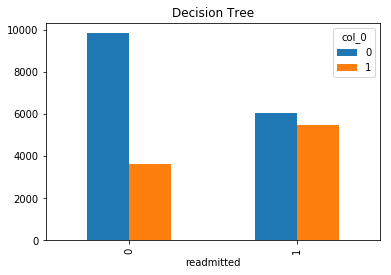

In [36]:
tree_pred = decision_tree.predict(X_test)
pd.crosstab(y_test, tree_pred).plot.bar(title = 'Decision Tree')

Text(0.5,1,'ROC curves')

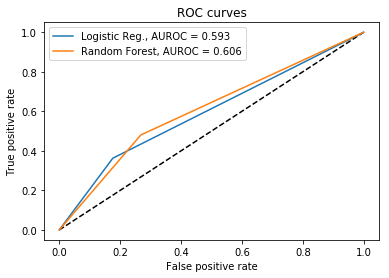

In [103]:
from sklearn.metrics import roc_curve, auc
fpr_lr, tpr_lr, _ = roc_curve(y_test, logreg_pred)
fpr_rf, tpr_rf, _ = roc_curve(y_test, forest_pred)

auroc1 = auc(fpr_lr, tpr_lr, True)
auroc2 = auc(fpr_rf, tpr_rf, True)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='Logistic Reg., AUROC = '+str(auroc1)[:5])
plt.plot(fpr_rf, tpr_rf, label='Random Forest, AUROC = '+str(auroc2)[:5])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc = 'best')
plt.title('ROC curves')

In [59]:
diags.head()

,diag_1,diag_2,diag_3
1,276,250.01,255
2,648,250,V27
3,8,250.43,403
4,197,157,250
5,414,411,250


In [69]:
for col in ['diag_1','diag_2','diag_3']:
    diags[col] = diags[col].map(lambda x: x.split('.')[0])


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,diag_1,diag_2,diag_3
31823,345,496,599
85676,410,496,396
96933,574,733,568
51062,428,493,276
68880,434,342,250
84472,787,276,8
98272,53,V42,V42
13811,562,491,250
41608,553,278,V10
77917,250,276,427


In [72]:
diags = diags.replace('250', 'Diabetes')

In [97]:
diags.replace(regex={r'^V.$':'Others'})

,diag_1,diag_2,diag_3
1,276,Diabetes,255
2,648,Diabetes,V27
3,8,Diabetes,403
4,197,157,Diabetes
5,414,411,Diabetes
6,414,411,V45
7,428,492,Diabetes
8,398,427,38
9,434,198,486
10,Diabetes,403,996


In [94]:
df.replace(regex={r'^ba.$':'new', 'foo':'xyz'})

,A,B
0,new,abc
1,xyz,new
2,bait,xyz
